# Your Title Here

**Name(s)**: (your name(s) here)

**Website Link**: (your website link)

In [135]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from tabulate import tabulate
from IPython.core.display import display, HTML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
import scipy.stats as stats

import plotly.express as px
pd.options.plotting.backend = 'plotly'

# from lec_utils import * # Feel free to uncomment and use this. It'll make your plotly graphs look like ours in lecture!

/var/folders/3r/h9skfdh12kg2nztqjg7tdhj80000gn/T/ipykernel_56233/3176251559.py:5: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



## Step 1: Introduction

In this project, I investigate a comprehensive dataset published by Purdue University that catalogued power outages across the United States, along with a suite of external variables recorded for each outage. These additional features include geographical location of the outages, regional climate classifications, land-use characteristics, electricity consumption patterns and economic characteristics of the states affected by the outages. 

Initially, I needed to clean the data and perform an initial foray into analyzing the dataset. It contains over 1500 rows, with some more niche columns –– for example, HURRICANE_NAME –– being largely null. As a result, I first needed to sanitize, organize and normalize the dataset. 

Then, I explored a univariate analysis, focusing on three different variables in three different studies. These were: THREE VARIABLES. My hypotheses for these three variables were as follows: HYPOTHESES.

Next, I wanted to dive deeper into a bivariate analysis, leveraging combined and related features to better understand patterns in the dataset, and thus build a better predictive model. 

## Step 2: Data Cleaning and Exploratory Data Analysis

In [5]:
# first, need to import data and re-factor the excel dataset to be properly represented in a DataFrame
def import_data():
    df = pd.read_excel('outage.xlsx', skiprows=4)
    df.columns = df.iloc[0]
    df = df.drop(0)
    df = df.reset_index(drop=True)
    units = df.iloc[0].dropna().to_dict()
    df = df.drop(0)

    return units, df

In [103]:
def clean_impute(df):
    df_cleaned = df.copy()
    # Impute missing values for numerical features
    numerical_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
    df_cleaned[numerical_columns] = df_cleaned[numerical_columns].fillna(df_cleaned[numerical_columns].mean())
    
    # Impute missing values for categorical features
    categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
    df_cleaned[categorical_columns] = df_cleaned[categorical_columns].fillna(df_cleaned[categorical_columns].mode().iloc[0])
    
    # Check if there are any missing values left
    # print("\nMissing values after cleaning:")
    # print(df_cleaned.isnull().sum())

    # Custom imputation scheme for columns of interest
    df['QUARTER'] = df['MONTH'].apply(lambda x: (x - 1) // 3 + 1)

    # Calculate the most common CAUSE.CATEGORY.DETAIL for each POSTAL.CODE and QUARTER combination
    common_details = df.groupby(['POSTAL.CODE', 'QUARTER'])['CAUSE.CATEGORY.DETAIL'].apply(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index()
    
    # Merge this common_details back with the original DataFrame to use for imputation
    df = df.merge(common_details, on=['POSTAL.CODE', 'QUARTER'], how='left', suffixes=('', '_IMPUTED'))
    
    # Impute missing values in "CAUSE.CATEGORY.DETAIL" with the most common value from the same postal code and quarter
    df['CAUSE.CATEGORY.DETAIL'] = df['CAUSE.CATEGORY.DETAIL'].fillna(df['CAUSE.CATEGORY.DETAIL_IMPUTED'])
    
    # Drop the temporary imputed column
    df = df.drop(columns=['CAUSE.CATEGORY.DETAIL_IMPUTED'])

    return df_cleaned

In [104]:
units, df = import_data()

In [105]:
df = clean_impute(df)

In [107]:
df['CAUSE.CATEGORY.DETAIL']

1          vandalism
2          vandalism
3         heavy wind
4       thunderstorm
5          vandalism
            ...     
1530       vandalism
1531            Coal
1532       vandalism
1533       vandalism
1534         failure
Name: CAUSE.CATEGORY.DETAIL, Length: 1534, dtype: object

In [33]:
columns_of_interest = ['MONTH', 'U.S._STATE', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY', 'OUTAGE.START.TIME', 'OUTAGE.START.DATE',
                       'OUTAGE.DURATION', 'CAUSE.CATEGORY', 'CUSTOMERS.AFFECTED']

In [34]:
df_interest = df[columns_of_interest]

In [32]:
# Create a pivot table to summarize the data
pivot_table = df_interest.pivot_table(
    values='OUTAGE.DURATION',    # Target variable: Average Outage Duration
    index=['MONTH', 'U.S._STATE', 'ANOMALY.LEVEL', 'CAUSE.CATEGORY'],  # Group by these columns
    aggfunc='mean',  # We are interested in the average outage duration
    fill_value=0  # Fill missing values with 0 if there are any
)

# Display the pivot table
html_output = pivot_table.to_html()
md_output = pivot_table.to_markdown()
# display(HTML(html_output))(pivot_table)

In [114]:
print(f"anomaly range: [{df['ANOMALY.LEVEL'].min()}, {df['ANOMALY.LEVEL'].max()}]")

anomaly range: [-1.6, 2.3]


## Univariate Anaylsis

### Analysis 1) Outage Start Time vs. Outage Duration

In [26]:
outage_start_time = df["OUTAGE.START.TIME"]
outage_duration = df["OUTAGE.DURATION"]

/var/folders/3r/h9skfdh12kg2nztqjg7tdhj80000gn/T/ipykernel_56233/1828447749.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



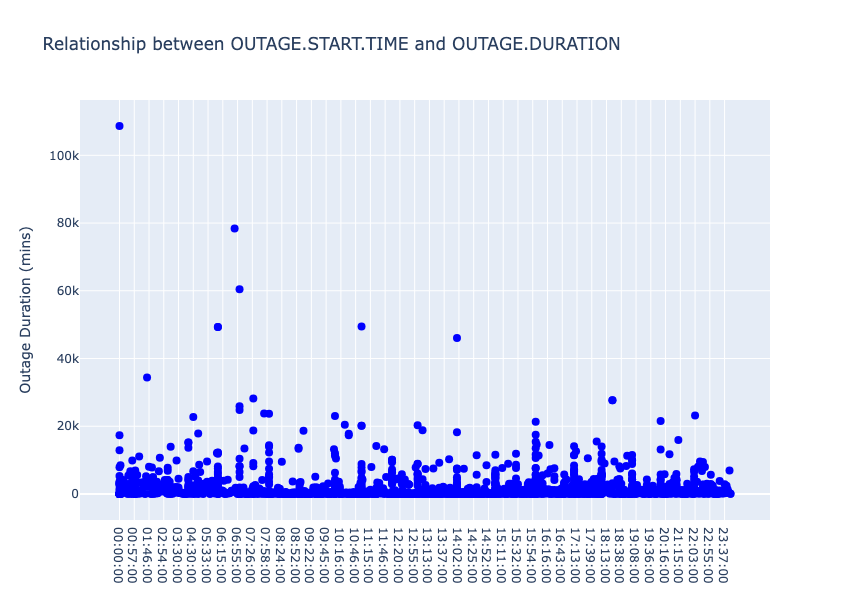

In [128]:
df_extracted = df_interest[['OUTAGE.START.TIME', 'OUTAGE.DURATION']]
df_extracted['OUTAGE.DURATION'] = df_extracted['OUTAGE.DURATION']
df_sorted = df_extracted.sort_values(by='OUTAGE.START.TIME')
labels = {
    'title': 'Relationship between OUTAGE.START.TIME and OUTAGE.DURATION',
    'xtitle': 'Outage Start Time',
    'ytitle': 'Outage Duration (mins)'
}
f1 = gen_uni_scatter(df_sorted['OUTAGE.START.TIME'], df_sorted['OUTAGE.DURATION'], labels)

f1.show()
fig.write_html('fig1.html', include_plotlyjs='cdn')

## Analysis 2) Outage Month vs Outage Duration

/var/folders/3r/h9skfdh12kg2nztqjg7tdhj80000gn/T/ipykernel_56233/4218814543.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



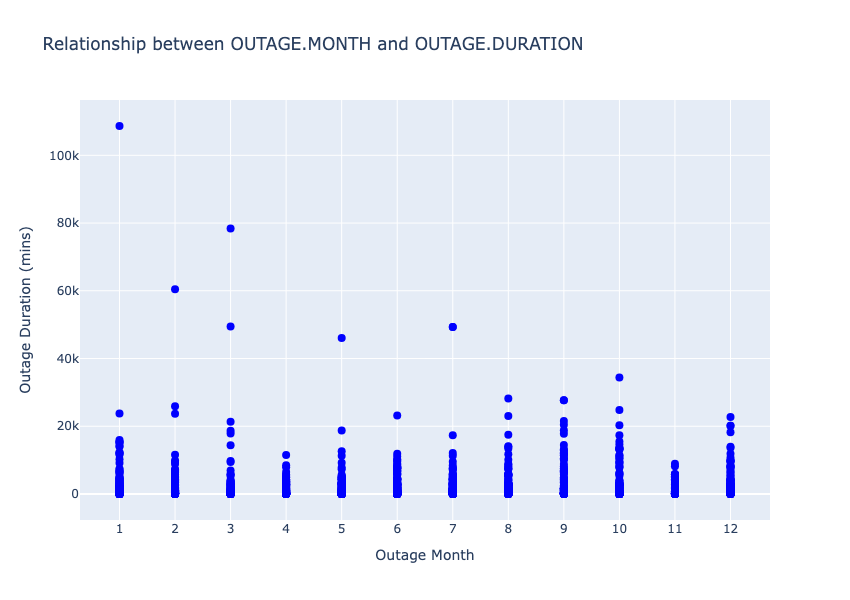

In [129]:
df2 = df_interest[['OUTAGE.START.DATE', 'OUTAGE.DURATION']]
df2['OUTAGE.MONTH'] = pd.to_datetime(df2['OUTAGE.START.DATE']).dt.month
labels = {
    'title': 'Relationship between OUTAGE.MONTH and OUTAGE.DURATION',
    'xtitle': 'Outage Month',
    'ytitle': 'Outage Duration (mins)',
    'xaxis': dict(dtick=1)
}

f2 = gen_uni_scatter(df2['OUTAGE.MONTH'], df2['OUTAGE.DURATION'], labels)
f2.show()
fig.write_html('fig2.html', include_plotlyjs='cdn')

## Analysis 3) Outage Cause Category vs Outage Duration

AVG.DURATION by CAUSE.CATEGORY: CAUSE.CATEGORY
fuel supply emergency            3960.0
severe weather                   2460.0
public appeal                     455.0
equipment failure                 221.0
system operability disruption     215.0
islanding                          77.5
intentional attack                 56.0
Name: OUTAGE.DURATION, dtype: object


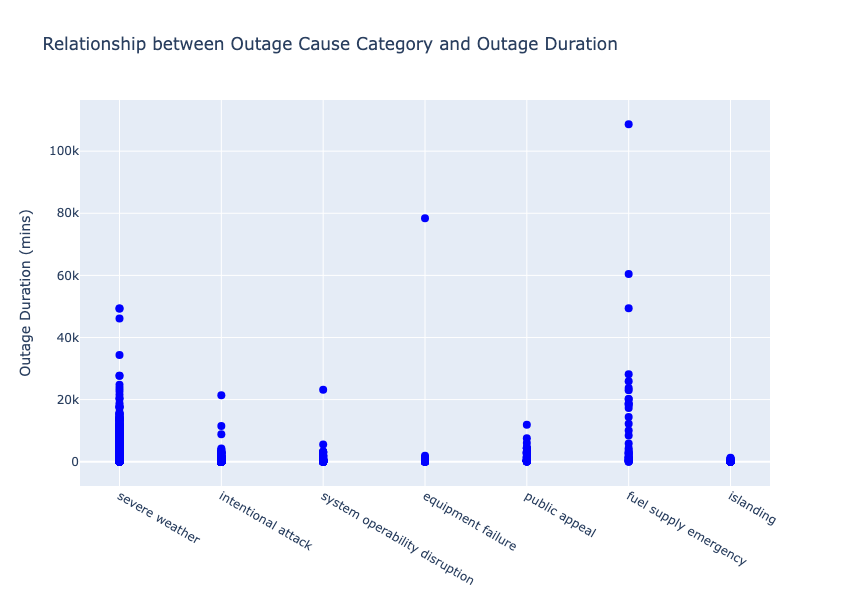

In [130]:
df3 = df_interest[['CAUSE.CATEGORY', 'OUTAGE.DURATION']]
average_outage_duration = df3.groupby('CAUSE.CATEGORY')['OUTAGE.DURATION'].median().sort_values(ascending=False)
print(f"AVG.DURATION by CAUSE.CATEGORY: {average_outage_duration}")
labels = {
    'title': 'Relationship between Outage Cause Category and Outage Duration',
     'xtitle': 'Outage Cause Category',
     'ytitle': 'Outage Duration (mins)',
     }
f3 = gen_uni_scatter(df3['CAUSE.CATEGORY'], df3['OUTAGE.DURATION'], labels)
f3.show()
fig.write_html('fig3.html', include_plotlyjs='cdn')

In [131]:
# Helper function to generate standardized Plotly scatter plots for Univariate Analysis
def gen_uni_scatter(x, y, labels):
    fig = go.Figure()

    # Add scatter plot to the figure
    fig.add_trace(go.Scatter(
        x=x,
        y=y, 
        mode='markers', 
        marker=dict(color='blue', size=8),
        name='Power Outages'
    ))
    
    # Add titles and labels
    fig.update_layout(
        title=labels['title'],
        xaxis_title=labels['xtitle'],
        yaxis_title=labels['ytitle'],
        xaxis=labels.get('xaxis'),
        template='plotly',
        height=600,
        width=800
    )
    
    return fig

## Bivariate Analysis

## Analysis 1) Climate Category and Cause Category vs Outage Duration

## Analysis 2) Cause Category and Cause Category Detail vs Outage Duration

## Analysis 3) 

## Step 3: Framing a Prediction Problem

## Step 4: Baseline Model

In [85]:
# Defining features and target variable
X = df[['CLIMATE.CATEGORY', 'ANOMALY.LEVEL', 'CAUSE.CATEGORY.DETAIL','TOTAL.CUSTOMERS', 'RES.CUST.PCT']]  # Features
y = df['CUSTOMERS.AFFECTED']  # Target variable

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=398)

# Define preprocessing for numerical and categorical features
numeric_features = ['ANOMALY.LEVEL', 'TOTAL.CUSTOMERS', 'RES.CUST.PCT']
categorical_features = ['CLIMATE.REGION', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL', 'CLIMATE.CATEGORY']

# Create the preprocessing pipeline for numeric and categorical columns
# Numeric: Fill missing values, then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values by imputing with mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Categorical: Fill missing values, then encode using OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing with most frequent
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoder for categorical data
])

# Combine both transformations into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the final pipeline with preprocessing + RandomForestRegressor (you can use other models too)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing to the data
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # Model training step
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate the model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
# Calculate the range of the target variable
target_range = y_train.max() - y_train.min()

# Compute the Normalized Mean Absolute Error (NMAE)
nmae = mae / target_range

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Normalized MAE (NMAE): {nmae}")

# Optionally, you can use cross-validation to assess model generalization
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validated MAE: {-cv_scores.mean()}")

/Users/davidlisbonne/Documents/UM/SuperDuperSenior/398practicalds/env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Mean Absolute Error (MAE): 113091.42935718407
Root Mean Squared Error (RMSE): 361272.1045702723
Normalized MAE (NMAE): 0.04075230248398309
Cross-validated MAE: 97469.10687404158


## Step 5: Final Model

In [89]:
def create_new_features(df):
    # Log-transforming the target feature to handle skewed distribution
    df['LOG_CUSTOMERS_AFFECTED'] = np.log1p(df['CUSTOMERS.AFFECTED'])
    
    # Creating a new feature: Residential Customers in Region
    df['RES.CUSTOMERS'] = df['POPULATION'] * df['RES.CUST.PCT'] / 100
    return df

# Load and preprocess data
df = create_new_features(df)  # Apply feature engineering
X = df.drop(columns=['OUTAGE.DURATION'])  # Feature set
y = df['OUTAGE.DURATION']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps for numerical and categorical features
numeric_features = ['POPULATION', 'ANOMALY.LEVEL', 'RES.CUST.PCT', 'RES.CUSTOMERS', 'LOG_CUSTOMERS_AFFECTED']
categorical_features = ['U.S._STATE', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY']

# For numerical features, we apply imputation (in case of missing values) and scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# For categorical features, we apply imputation (in case of missing values) and encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the transformers into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Model setup: RandomForestRegressor with GridSearchCV for hyperparameter tuning
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define hyperparameters for GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200],   # Number of trees in the forest
    'regressor__max_depth': [None, 10, 20],   # Maximum depth of the trees
    'regressor__min_samples_split': [2, 5],   # Minimum number of samples required to split a node
    'regressor__min_samples_leaf': [1, 2]     # Minimum number of samples required at a leaf node
}

# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')

# Train the model
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Print best params
print(f"Best parameteres from grid search: {grid_search.best_params_}")

# Evaluate the model
y_pred = best_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE) for Final Model: {mae}")

# Calculate NMAE
nmae = mae / (y.max() - y.min())
print(f"Normalized Mean Absolute Error (NMAE) for Final Model: {nmae}")

Best parameteres from grid search: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Mean Absolute Error (MAE) for Final Model: 2420.3930900091705
Normalized Mean Absolute Error (NMAE) for Final Model: 0.022276357670834402


In [133]:
residuals

1365    -2601.443310
77     -12003.497298
317     -2093.401875
1090     -224.158278
1357     -217.135095
            ...     
1182    32347.679173
846         9.774608
1332      607.764919
234     -9141.081619
1497      119.992476
Name: OUTAGE.DURATION, Length: 307, dtype: float64

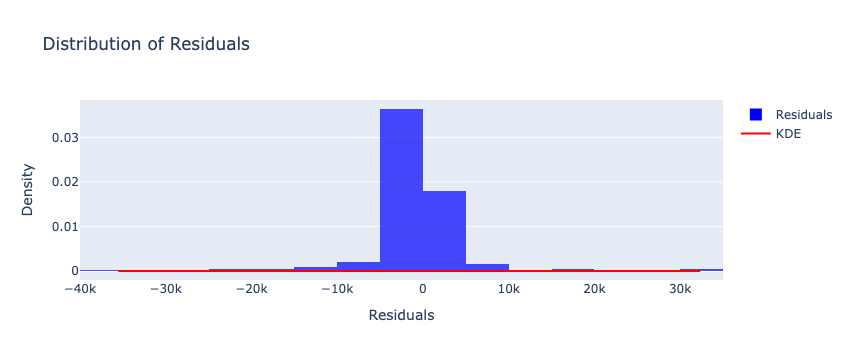

In [137]:
hist_trace = go.Histogram(
    x=residuals,
    histnorm='density',  # Normalize the histogram to show density (similar to KDE)
    name='Residuals',
    nbinsx=30,  # You can adjust the number of bins here
    marker=dict(color='blue', opacity=0.7)
)

# Calculate the KDE using scipy.stats.gaussian_kde
kde = stats.gaussian_kde(residuals)
kde_x = np.linspace(min(residuals), max(residuals), 1000)
kde_y = kde(kde_x)

# Create a KDE line trace
kde_trace = go.Scatter(
    x=kde_x,
    y=kde_y,
    mode='lines',
    name='KDE',
    line=dict(color='red')
)

# Create the figure
fig = go.Figure(data=[hist_trace, kde_trace])

# Customize the layout
fig.update_layout(
    title='Distribution of Residuals',
    xaxis_title='Residuals',
    yaxis_title='Density',
    showlegend=True
)

# Show the interactive plot
fig.show()

# Optionally, save the plot as an HTML file
fig.write_html("finalmodelresiduals.html", include_plotlyjs='cdn')

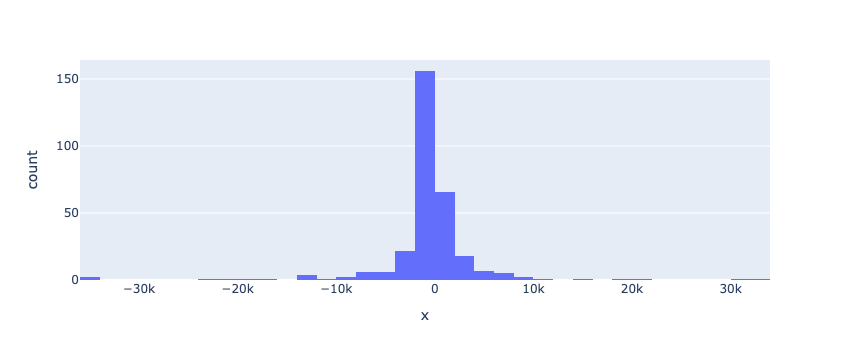

In [139]:
fig = px.histogram(x=residuals)
fig.show()